##  estimate phenology from gimms ndvi

1. process raw ndvi data: choose site covered by plant, replace negative ndvi, savgol-filter

2. fit model to get daily ndvi sequence

3. get phenology using threshold or change point


In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import glob
import dask

In [2]:
import savitzky_golay
import numpy.polynomial.polynomial as poly
import scipy.interpolate as spi
from dask.diagnostics import ProgressBar

In [3]:
def read_ndvi_data(paths):
    ndvi = []
    for file in paths:
        print(file)
        
        with xr.open_dataset(file,chunks=({'lat':1000,'lon':100})) as ndvi_i:
            ndvi.append(ndvi_i['ndvi'])
        
    ndvi_data = xr.concat(ndvi, dim = 'time')
    ndvi_data = ndvi_data.sortby('time')
        
    ndvi_data = ndvi_data.chunk({'lat':1000, 'lon':100, 'time':-1})
        
    return ndvi_data

In [4]:
def dbl_logistic_model(p, doys):
    y = p[0] + p[1] * (1./(1+np.exp(p[2]*(doys-p[3]))) + 
                      1./(1 + np.exp(-p[4]*(doys - p[5]))))
    return y

In [5]:
def mismatch_function(p, pheno_func, data, days):
    output = []
    
    fitness = lambda p, data_in, days: data_in - pheno_func(p, days)
    
    oot = fitness( p , data, days)
    [output.append(x) for x in oot]
    
    return np.array(output).squeeze()

In [6]:
def fit_double_logistic(data, t_axis, xinit = None):
    
    from scipy.optimize import leastsq
    
    pheno_func = dbl_logistic_model
    
    n_params = 6
    if xinit is None:
        xinit = [.5,] * n_params
        xinit[0] = data.min()
        xinit[1] = data.max() - data.min()
        xinit[2] = 0.19
        xinit[3] = 120
        xinit[4] = 0.13
        xinit[5] = 260
        
    (xsol , msg) = leastsq(mismatch_function, xinit, maxfev=1000000,
                           args = (pheno_func, data ,t_axis))
    
    ax = pheno_func( xsol, np.arange(1,366))
    
    return (xsol, msg, ax)
        

In [7]:
def piece_logistic(p,doys):
    y = p[0] + (p[1] - p[0])/(1+np.exp(p[2]*(p[3]-doys)))
    
    return y

In [8]:
def fit_piece_logistic( data, t_axis, xinit = None, season = 'sos'):
    from scipy.optimize import leastsq
    
    pheno_func = piece_logistic
    n_params = 4
    
    if xinit is None:
        xinit = [.5] * n_params
        
        xinit[0] = data.min()
        xinit[1] = data.max()
        xinit[2] = 0.15
        
        if season == 'sos':
            xinit[3] = 120
        else:
            xinit[3] = 250
        
    (xsol, msg) = leastsq( mismatch_function,xinit, maxfev= 1000000,
                         args = (pheno_func, data, t_axis))
    
    if season == 'sos':
        ax = pheno_func(xsol, np.arange(1,t_axis.max()))
    else:
        ax = pheno_func(xsol, np.arange(t_axis.min(),t_axis.max()))
    return (xsol, msg, ax)

In [9]:
def get_ndvi_phenology(ndvi_data, ndvi_mean):
    
    phenos = np.full(8, np.nan)
    
    ## check data of points
    if np.sum(np.isnan(ndvi_data)) < 12 and ndvi_mean > 0.1 :
        
        #doy = np.arange(8,365,15)  ## gimms ndvi
        doy = np.arange(8,365,16)  ## modis 16d ndvi
        ndvi_data = np.nan_to_num(ndvi_data, nan = ndvi_mean)
        growing_season = np.mean(ndvi_data[10:16])
        non_growing_1 = np.mean(ndvi_data[np.arange(6)])
        non_growing_2 = np.mean(ndvi_data[np.arange(20,len(ndvi_data))])
        non_growing_season = np.mean([non_growing_1,non_growing_2])
        
        doy_mid_raw = doy[ndvi_data.argmax()]
        is_mid = doy_mid_raw > 150 and doy_mid_raw < 270
        
        if growing_season > (1.2*non_growing_season)  and is_mid:
            
            ## SG-filter
            ndvi_data = np.asarray(ndvi_data[:len(doy)])
            ndvi_data_sg = savitzky_golay.savitzky_golay(ndvi_data,15,4)
            
            #plt.plot(ndvi_data_sg)
            ## divide into spr_data and aut_data
            index_mid = ndvi_data_sg.argmax()
            doy_mid = doy[index_mid]
            
            if doy_mid >160 and doy_mid < 220: 
                doy_spr = doy[:index_mid]
                doy_aut = doy[index_mid:]

                data_sg_spr = ndvi_data_sg[:index_mid]
                data_sg_aut = ndvi_data_sg[index_mid:]
            
            else:
                doy_spr = doy[doy <= 200]
                doy_aut = doy[doy > 170]
            
                data_sg_spr = ndvi_data_sg[doy <= 200]
                data_sg_aut = ndvi_data_sg[doy > 170]
            
            ## method 1: poly 50%
            poly_model = poly.polyfit(doy,ndvi_data_sg,6)
            poly_ndvi = poly.polyval(np.arange(1,366),poly_model)
            
            poly_ratio = (poly_ndvi- poly_ndvi.min()) / (poly_ndvi.max() - 
                                              poly_ndvi.min())
            
            if len(poly_ratio) > 0:
                phenos[0] = np.asarray(poly_ratio > 0.5).nonzero()[0][0]
                phenos[4] = np.asarray(poly_ratio > 0.5).nonzero()[0][-1]    
            
            ## method 2: spline 50%
            spi_spline = spi.splrep(doy,ndvi_data_sg,k=3)
            result_spline_3 = spi.splev(np.arange(1,366),spi_spline)

            ratio_spline = (result_spline_3 - result_spline_3.min()) / (
                result_spline_3.max() - result_spline_3.min())
            
            if len(np.asarray(ratio_spline > 0.5).nonzero()[0]) > 0:
                phenos[1] = np.asarray(ratio_spline > 0.5).nonzero()[0][0]
                phenos[5] = np.asarray(ratio_spline > 0.5).nonzero()[0][-1]
    
            ## method 3: dlog
            dlog_model = fit_double_logistic(ndvi_data_sg,doy)    
            
            dbl_fitted_ndvi = dlog_model[2]
            
            if len(dbl_fitted_ndvi) > 0:
                dbl_ndvi_1der = np.diff(dbl_fitted_ndvi)
            
                phenos[2] = np.arange(1,365)[dbl_ndvi_1der.argmax()]
                phenos[6] = np.arange(1,365)[dbl_ndvi_1der.argmin()]
    
            ## method 4: plog
            plog_spr = fit_piece_logistic(data_sg_spr, doy_spr)
            plog_aut = fit_piece_logistic(data_sg_aut, doy_aut, season = 'aut')
            
            if len(plog_spr[2]) > 0:
                plog_fitted_ndvi_spr = plog_spr[2]
                plog_spr_1der = np.diff(plog_fitted_ndvi_spr)
                
                phenos[3] = np.arange(1,doy_spr.max())[plog_spr_1der.argmax()]
                
            if len(plog_aut[2]) > 0:
                plog_fitted_ndvi_aut = plog_aut[2]
                plog_aut_1der = np.diff(plog_fitted_ndvi_aut)
            
                phenos[7] = np.arange(doy_aut.min(),366)[plog_aut_1der.argmin()]

    
    return phenos


In [10]:
def ndvi_pheno(x,ndvi_mean):
    return xr.apply_ufunc(
        get_ndvi_phenology,
        x,
        ndvi_mean,
        input_core_dims = [['time'],[]],
        output_core_dims = [['pheno']],
        dask_gufunc_kwargs = {'output_sizes':{'pheno':8}},
        vectorize = True,
        dask = 'parallelized',
        output_dtypes= [float]
    )

In [11]:
start_year = 2001
end_year = 2020
lat_lon = '-75-70'

In [12]:
ndvi_path = glob.glob(r'file_path'+'*.nc')

In [13]:
ndvi_data = read_ndvi_data(ndvi_path)

file1
file2


C:\Users\.conda\envs\geo\lib\site-packages\xarray\core\indexing.py:1379: PerformanceWarning: Slicing with an out-of-order index is generating 22 times more chunks
  return self.array[key]


In [14]:
ndvi_data

<xarray.DataArray 'ndvi' (lat: 3105, lon: 600, time: 482)>
dask.array<rechunk-merge, shape=(3105, 600, 482), dtype=float32, chunksize=(1000, 100, 482), chunktype=numpy.ndarray>
Coordinates:
  * time      (time) object 2000-02-18 00:00:00 ... 2020-12-18 00:00:00
  * lat       (lat) float64 49.92 49.91 49.9 49.9 ... 24.08 24.07 24.06 24.05
  * lon       (lon) float64 -75.0 -74.99 -74.98 -74.97 ... -70.02 -70.01 -70.0
    quantile  (time) float64 dask.array<chunksize=(482,), meta=np.ndarray>

In [15]:
ndvi_mean = ndvi_data.mean(dim = 'time', skipna =True)

# test functions

In [19]:
ndvi_year = ndvi_data.groupby('time.year')[2001]

array([120., 121., 127., 125., 364., 364., 263., 266.])

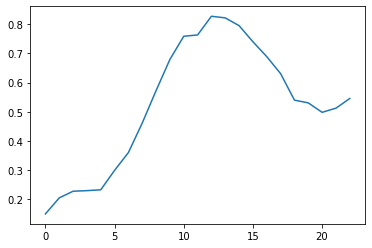

In [26]:
point_data = ndvi_year[100,100,:].values
point_data

get_ndvi_phenology(point_data, 0.6)

# get phenology by year

In [16]:
for year in range(start_year, end_year+1):
    
    print('now calculting....',year)
    
    ndvi_year = ndvi_data.groupby('time.year')[year]
    
    result = ndvi_pheno(ndvi_year, ndvi_mean)
    
    with ProgressBar():
        result_phenos = result.compute()
        
    pheno_list = year*100 + np.asarray([11,12,13,14,21,22,23,24])
    
    result_phenos['pheno'] = pheno_list
    result_phenos.name = 'phenology'
    
    result_phenos.to_netcdf(path = 'D:/aithc/phd/data/modis_ndvi/pheno/'+str(year)+lat_lon+'.nc',
                           encoding = {'phenology':{'dtype':'int16','_FillValue':-9999,
                                                   'zlib':True,'complevel':9}})

now calculting.... 2001
[####################################    ] | 91% Completed | 54.2s

C:\Users\aithc\.conda\envs\geo\lib\site-packages\dask\array\numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[######################################  ] | 95% Completed | 58.0s

C:\Users\aithc\.conda\envs\geo\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


[######################################  ] | 95% Completed |  1min 59.4s

C:\Users\aithc\.conda\envs\geo\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


[######################################  ] | 95% Completed | 27min 15.1s

C:\Users\aithc\.conda\envs\geo\lib\site-packages\scipy\optimize\minpack.py:475: RuntimeWarning: Number of calls to function has reached maxfev = 1000000.
  warnings.warn(errors[info][0], RuntimeWarning)


[########################################] | 100% Completed |  7hr 10min 24.1s
now calculting.... 2002
[####################################    ] | 91% Completed | 32.1s

C:\Users\aithc\.conda\envs\geo\lib\site-packages\dask\array\numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[######################################  ] | 95% Completed | 34.5s

C:\Users\aithc\.conda\envs\geo\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


[######################################  ] | 95% Completed | 37.4s

C:\Users\aithc\.conda\envs\geo\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


[######################################  ] | 95% Completed |  1hr  6min 24.3s

C:\Users\aithc\.conda\envs\geo\lib\site-packages\scipy\optimize\minpack.py:475: RuntimeWarning: Number of calls to function has reached maxfev = 1000000.
  warnings.warn(errors[info][0], RuntimeWarning)


[########################################] | 100% Completed |  4hr 46min 56.1s
now calculting.... 2003
[####################################    ] | 91% Completed | 31.6s

C:\Users\aithc\.conda\envs\geo\lib\site-packages\dask\array\numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[######################################  ] | 95% Completed | 34.0s

C:\Users\aithc\.conda\envs\geo\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


[######################################  ] | 95% Completed | 38.4s

C:\Users\aithc\.conda\envs\geo\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


[######################################  ] | 95% Completed | 50min 22.8s

C:\Users\aithc\.conda\envs\geo\lib\site-packages\scipy\optimize\minpack.py:475: RuntimeWarning: Number of calls to function has reached maxfev = 1000000.
  warnings.warn(errors[info][0], RuntimeWarning)


[########################################] | 100% Completed |  5hr 35min 13.1s
now calculting.... 2004
[####################################    ] | 91% Completed | 43.2s

C:\Users\aithc\.conda\envs\geo\lib\site-packages\dask\array\numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[######################################  ] | 95% Completed | 46.7s

C:\Users\aithc\.conda\envs\geo\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


[######################################  ] | 95% Completed | 51.5s

C:\Users\aithc\.conda\envs\geo\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


[######################################  ] | 95% Completed |  3hr 25min  1.1s

C:\Users\aithc\.conda\envs\geo\lib\site-packages\scipy\optimize\minpack.py:475: RuntimeWarning: Number of calls to function has reached maxfev = 1000000.
  warnings.warn(errors[info][0], RuntimeWarning)


[########################################] | 100% Completed |  5hr 50min 48.2s
now calculting.... 2005
[####################################    ] | 90% Completed | 38.2s

C:\Users\aithc\.conda\envs\geo\lib\site-packages\dask\array\numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[######################################  ] | 95% Completed | 41.2s

C:\Users\aithc\.conda\envs\geo\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


[######################################  ] | 95% Completed |  1min 19.7s

C:\Users\aithc\.conda\envs\geo\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


[######################################  ] | 95% Completed | 16min 26.9s

C:\Users\aithc\.conda\envs\geo\lib\site-packages\scipy\optimize\minpack.py:475: RuntimeWarning: Number of calls to function has reached maxfev = 1000000.
  warnings.warn(errors[info][0], RuntimeWarning)


[########################################] | 100% Completed |  4hr  9min 34.2s
now calculting.... 2006
[####################################    ] | 90% Completed |  1min 20.9s

C:\Users\aithc\.conda\envs\geo\lib\site-packages\dask\array\numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[######################################  ] | 95% Completed |  1min 26.5s

C:\Users\aithc\.conda\envs\geo\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


[######################################  ] | 95% Completed |  1min 55.2s

C:\Users\aithc\.conda\envs\geo\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


[######################################  ] | 95% Completed |  2hr  5min 45.7s

C:\Users\aithc\.conda\envs\geo\lib\site-packages\scipy\optimize\minpack.py:475: RuntimeWarning: Number of calls to function has reached maxfev = 1000000.
  warnings.warn(errors[info][0], RuntimeWarning)


[########################################] | 100% Completed | 12hr 22min  9.3s
now calculting.... 2007
[####################################    ] | 91% Completed | 32.8s

C:\Users\aithc\.conda\envs\geo\lib\site-packages\dask\array\numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[######################################  ] | 95% Completed | 35.4s

C:\Users\aithc\.conda\envs\geo\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


[######################################  ] | 95% Completed | 45.9s

C:\Users\aithc\.conda\envs\geo\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


[######################################  ] | 95% Completed | 41min 59.2s

C:\Users\aithc\.conda\envs\geo\lib\site-packages\scipy\optimize\minpack.py:475: RuntimeWarning: Number of calls to function has reached maxfev = 1000000.
  warnings.warn(errors[info][0], RuntimeWarning)


[########################################] | 100% Completed |  3hr  0min 10.9s
now calculting.... 2008
[####################################    ] | 90% Completed | 35.5s

C:\Users\aithc\.conda\envs\geo\lib\site-packages\dask\array\numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[######################################  ] | 95% Completed | 38.4s

C:\Users\aithc\.conda\envs\geo\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


[######################################  ] | 95% Completed | 41.8s

C:\Users\aithc\.conda\envs\geo\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


[######################################  ] | 95% Completed |  6min 36.0s

C:\Users\aithc\.conda\envs\geo\lib\site-packages\scipy\optimize\minpack.py:475: RuntimeWarning: Number of calls to function has reached maxfev = 1000000.
  warnings.warn(errors[info][0], RuntimeWarning)


[########################################] | 100% Completed |  4hr 53min 16.2s
now calculting.... 2009
[####################################    ] | 90% Completed | 44.7s

C:\Users\aithc\.conda\envs\geo\lib\site-packages\dask\array\numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[######################################  ] | 95% Completed | 53.7s

C:\Users\aithc\.conda\envs\geo\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


[######################################  ] | 95% Completed |  1min 11.9s

C:\Users\aithc\.conda\envs\geo\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


[######################################  ] | 95% Completed |  1hr 29min 34.4s

C:\Users\aithc\.conda\envs\geo\lib\site-packages\scipy\optimize\minpack.py:475: RuntimeWarning: Number of calls to function has reached maxfev = 1000000.
  warnings.warn(errors[info][0], RuntimeWarning)


[########################################] | 100% Completed |  9hr 51min  3.7s
now calculting.... 2010
[####################################    ] | 90% Completed | 33.4s

C:\Users\aithc\.conda\envs\geo\lib\site-packages\dask\array\numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[######################################  ] | 95% Completed | 36.1s

C:\Users\aithc\.conda\envs\geo\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


[######################################  ] | 95% Completed |  2min 55.9s

C:\Users\aithc\.conda\envs\geo\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


[######################################  ] | 95% Completed | 22min 26.5s

C:\Users\aithc\.conda\envs\geo\lib\site-packages\scipy\optimize\minpack.py:475: RuntimeWarning: Number of calls to function has reached maxfev = 1000000.
  warnings.warn(errors[info][0], RuntimeWarning)


[########################################] | 100% Completed |  7hr 23min 13.1s
now calculting.... 2011
[####################################    ] | 90% Completed | 46.0s

C:\Users\aithc\.conda\envs\geo\lib\site-packages\dask\array\numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[######################################  ] | 95% Completed | 49.6s

C:\Users\aithc\.conda\envs\geo\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


[######################################  ] | 95% Completed |  1min  8.3s

C:\Users\aithc\.conda\envs\geo\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


[######################################  ] | 95% Completed | 25min 37.4s

C:\Users\aithc\.conda\envs\geo\lib\site-packages\scipy\optimize\minpack.py:475: RuntimeWarning: Number of calls to function has reached maxfev = 1000000.
  warnings.warn(errors[info][0], RuntimeWarning)


[########################################] | 100% Completed |  8hr 31min 14.3s
now calculting.... 2012
[####################################    ] | 90% Completed | 33.8s

C:\Users\aithc\.conda\envs\geo\lib\site-packages\dask\array\numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[######################################  ] | 95% Completed | 36.4s

C:\Users\aithc\.conda\envs\geo\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


[######################################  ] | 95% Completed | 42.3s

C:\Users\aithc\.conda\envs\geo\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


[######################################  ] | 95% Completed |  5min 54.1s

C:\Users\aithc\.conda\envs\geo\lib\site-packages\scipy\optimize\minpack.py:475: RuntimeWarning: Number of calls to function has reached maxfev = 1000000.
  warnings.warn(errors[info][0], RuntimeWarning)


[########################################] | 100% Completed |  9hr 13min 42.5s
now calculting.... 2013
[####################################    ] | 91% Completed | 33.2s

C:\Users\aithc\.conda\envs\geo\lib\site-packages\dask\array\numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[######################################  ] | 95% Completed | 35.5s

C:\Users\aithc\.conda\envs\geo\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


[######################################  ] | 95% Completed | 43.3s

C:\Users\aithc\.conda\envs\geo\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


[######################################  ] | 95% Completed |  9min 17.3s

C:\Users\aithc\.conda\envs\geo\lib\site-packages\scipy\optimize\minpack.py:475: RuntimeWarning: Number of calls to function has reached maxfev = 1000000.
  warnings.warn(errors[info][0], RuntimeWarning)


[########################################] | 100% Completed |  5hr 33min 22.1s
now calculting.... 2014
[####################################    ] | 91% Completed | 33.4s

C:\Users\aithc\.conda\envs\geo\lib\site-packages\dask\array\numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[######################################  ] | 95% Completed | 36.4s

C:\Users\aithc\.conda\envs\geo\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


[######################################  ] | 95% Completed |  1min 16.2s

C:\Users\aithc\.conda\envs\geo\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


[######################################  ] | 96% Completed |  3hr 50min  5.9s

C:\Users\aithc\.conda\envs\geo\lib\site-packages\scipy\optimize\minpack.py:475: RuntimeWarning: Number of calls to function has reached maxfev = 1000000.
  warnings.warn(errors[info][0], RuntimeWarning)


[########################################] | 100% Completed |  5hr  4min 19.3s
now calculting.... 2015
[####################################    ] | 90% Completed | 32.5s

C:\Users\aithc\.conda\envs\geo\lib\site-packages\dask\array\numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[######################################  ] | 95% Completed | 35.3s

C:\Users\aithc\.conda\envs\geo\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


[######################################  ] | 95% Completed | 39.1s

C:\Users\aithc\.conda\envs\geo\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


[######################################  ] | 95% Completed |  3hr  2min 13.3s

C:\Users\aithc\.conda\envs\geo\lib\site-packages\scipy\optimize\minpack.py:475: RuntimeWarning: Number of calls to function has reached maxfev = 1000000.
  warnings.warn(errors[info][0], RuntimeWarning)


[########################################] | 100% Completed |  5hr 21min 31.7s
now calculting.... 2016
[####################################    ] | 91% Completed | 30.0s

C:\Users\aithc\.conda\envs\geo\lib\site-packages\dask\array\numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[######################################  ] | 95% Completed | 32.4s

C:\Users\aithc\.conda\envs\geo\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


[######################################  ] | 95% Completed |  2min 36.4s

C:\Users\aithc\.conda\envs\geo\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


[######################################  ] | 95% Completed |  1hr  6min 55.0s

C:\Users\aithc\.conda\envs\geo\lib\site-packages\scipy\optimize\minpack.py:475: RuntimeWarning: Number of calls to function has reached maxfev = 1000000.
  warnings.warn(errors[info][0], RuntimeWarning)


[########################################] | 100% Completed |  7hr 55min 31.7s
now calculting.... 2017
[####################################    ] | 91% Completed | 30.6s

C:\Users\aithc\.conda\envs\geo\lib\site-packages\dask\array\numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[######################################  ] | 95% Completed | 33.2s

C:\Users\aithc\.conda\envs\geo\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


[######################################  ] | 95% Completed | 53.9s

C:\Users\aithc\.conda\envs\geo\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


[######################################  ] | 95% Completed | 11min 40.4s

C:\Users\aithc\.conda\envs\geo\lib\site-packages\scipy\optimize\minpack.py:475: RuntimeWarning: Number of calls to function has reached maxfev = 1000000.
  warnings.warn(errors[info][0], RuntimeWarning)


[########################################] | 100% Completed |  3hr 57min 44.3s
now calculting.... 2018
[####################################    ] | 90% Completed | 31.7s

C:\Users\aithc\.conda\envs\geo\lib\site-packages\dask\array\numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[######################################  ] | 95% Completed | 34.4s

C:\Users\aithc\.conda\envs\geo\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


[######################################  ] | 95% Completed | 35.7s

C:\Users\aithc\.conda\envs\geo\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


[######################################  ] | 95% Completed | 40min 51.5s

C:\Users\aithc\.conda\envs\geo\lib\site-packages\scipy\optimize\minpack.py:475: RuntimeWarning: Number of calls to function has reached maxfev = 1000000.
  warnings.warn(errors[info][0], RuntimeWarning)


[########################################] | 100% Completed |  5hr 50min 42.0s
now calculting.... 2019
[####################################    ] | 90% Completed | 38.7s

C:\Users\aithc\.conda\envs\geo\lib\site-packages\dask\array\numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[######################################  ] | 95% Completed | 41.4s

C:\Users\aithc\.conda\envs\geo\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


[######################################  ] | 95% Completed |  4min 56.7s

C:\Users\aithc\.conda\envs\geo\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


[########################################] | 100% Completed |  5hr  7min 22.5s
now calculting.... 2020
[####################################    ] | 91% Completed | 50.1s

C:\Users\aithc\.conda\envs\geo\lib\site-packages\dask\array\numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[######################################  ] | 95% Completed | 53.9s

C:\Users\aithc\.conda\envs\geo\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


[######################################  ] | 95% Completed |  3min 26.7s

C:\Users\aithc\.conda\envs\geo\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


[######################################  ] | 95% Completed | 21min  9.9s

C:\Users\aithc\.conda\envs\geo\lib\site-packages\scipy\optimize\minpack.py:475: RuntimeWarning: Number of calls to function has reached maxfev = 1000000.
  warnings.warn(errors[info][0], RuntimeWarning)


[########################################] | 100% Completed |  9hr  0min 10.0s


0